# Recomendación para datos de compra, por ID

## La meta

Al resolver estos problemas, crearemos modelos de filtrado colaborativos para recomendar productos a los clientes utilizando datos de compra. En particular, cubriremos en detalle el proceso paso a paso en la construcción de un sistema de recomendación con Python y el módulo de aprendizaje automático Turicreate. Estos pasos incluyen:

#### Transformando y normalizando datos

#### Modelos de entrenamiento

#### Evaluación del desempeño del modelo

#### Seleccionando el modelo óptimo

#### Descripción del producto

La herramienta también podrá buscar una lista de recomendaciones basada en un usuario específico, de modo que:

#### Entrada: ID del cliente

#### Devoluciones: lista clasificada de artículos (ID de producto), que es más probable que el usuario quiera poner en su "cesta" (vacía)


## 1. Obtención de librerías necesarias

In [0]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import time
import turicreate as tc
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

import sys
sys.path.append("..")

## 2. Obtención de los datos

In [0]:
#Usaremos los datos de los clientes que repiten compras a lo largo del año analizado
data = pd.read_csv('Data.csv')
#Elimino la columna Unnamed: 0
data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [3]:
data.shape

(246858, 3)

## 3. Preparacion de Datos

Nuestro objetivo aquí es dividir cada lista de artículos en la columna de productos en filas y contar la cantidad de productos comprados por un usuario

### 3.1. Crear datos con usuario, elemento y campo de destino.

Chequeo si los datos importados llegan de acuerdo como lo pide el modelo usado.

Se adecuo en el notebook de preparacion de datos. Esta tabla será una entrada para nuestro modelado posterior

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246858 entries, 0 to 246857
Data columns (total 3 columns):
customerId        246858 non-null int64
productId         246858 non-null int64
purchase_count    246858 non-null int64
dtypes: int64(3)
memory usage: 5.7 MB


In [5]:
data.sample(5)

,customerId,productId,purchase_count
710,257,701,1
193753,95179,448,1
130633,52957,937,1
211363,111593,30,1
71616,25171,2421,1


In [6]:
#Sobre el Dataframe creado, generamos un subdataframe con los códigos de clientes:
customers = pd.DataFrame(data['customerId'].unique(), columns=['user_id'])
customers.sample(5)

,user_id
8758,22827
15536,42929
36695,139445
24669,75772
32440,112125


### 3.2. Crear dummy

¿Por qué crear un dummy en lugar de normalizarlo? Normalizar el recuento de compras, por ejemplo, por cada usuario, no funcionaría porque los clientes pueden tener diferentes frecuencias de compra y no tienen el mismo gusto. Sin embargo, podemos normalizar los artículos por frecuencia de compra en todos los usuarios, lo que se hace en la sección 3.3. 

In [0]:
def create_data_dummy(data):
    data_dummy = data.copy()
    data_dummy['purchase_dummy'] = 1
    return data_dummy

In [0]:
data_dummy = create_data_dummy(data)

### 3.3. Normalizar los items entre los usuarios

In [9]:
# Para hacer esto, normalizamos la frecuencia de compra de cada artículo entre los usuarios creando primero un artículo
# de usuario matriz de la siguiente manera
df_matrix = pd.pivot_table(data, values='purchase_count', index='customerId', columns='productId')
print(df_matrix.shape)
df_matrix.sample(5)

(39037, 2280)


productId,3,4,5,6,8,9,11,17,18,19,22,23,24,26,29,30,32,33,34,36,38,40,41,42,43,44,46,47,49,50,51,52,54,55,56,57,59,61,62,63,...,2766,2767,2769,2770,2772,2777,2778,2779,2780,2781,2782,2783,2784,2785,2790,2791,2793,2794,2795,2796,2797,2799,2800,2802,2803,2804,2805,2806,2807,2808,2810,2811,2812,2813,2814,2816,2817,2819,2823,2828
customerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
86430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df_matrix_norm = (df_matrix-df_matrix.min())/(df_matrix.max()-df_matrix.min())
print(df_matrix_norm.shape)
df_matrix_norm.sample(5)

(39037, 2280)


productId,3,4,5,6,8,9,11,17,18,19,22,23,24,26,29,30,32,33,34,36,38,40,41,42,43,44,46,47,49,50,51,52,54,55,56,57,59,61,62,63,...,2766,2767,2769,2770,2772,2777,2778,2779,2780,2781,2782,2783,2784,2785,2790,2791,2793,2794,2795,2796,2797,2799,2800,2802,2803,2804,2805,2806,2807,2808,2810,2811,2812,2813,2814,2816,2817,2819,2823,2828
customerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
51424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# crear una tabla para ingresar al modelado  
d = df_matrix_norm.reset_index() 
d.index.names = ['scaled_purchase_freq'] 
data_norm = pd.melt(d, id_vars=['customerId'], value_name='scaled_purchase_freq').dropna()
print(data_norm.shape)
data_norm.head()

(202870, 3)


,customerId,productId,scaled_purchase_freq
36,112,3,0.0
213,547,3,0.0
227,575,3,0.0
347,868,3,0.0
1094,2737,3,0.0


In [0]:
# Los pasos anteriores se pueden combinar con una función definida a continuación:
def normalize_data(data):
    df_matrix = pd.pivot_table(data, values='purchase_count', index='customerId', columns='productId')
    df_matrix_norm = (df_matrix-df_matrix.min())/(df_matrix.max()-df_matrix.min())
    d = df_matrix_norm.reset_index()
    d.index.names = ['scaled_purchase_freq']
    return pd.melt(d, id_vars=['customerId'], value_name='scaled_purchase_freq').dropna()
# En este paso, hemos normalizado su historial de compras, de 0 a 1 (donde 1 es la mayor cantidad de compras para 
# un artículo y 0 es 0 recuento de compras para ese artículo).

## 4. Split train and test set

Dividir los datos en conjuntos de entrenamiento y prueba es una parte importante de la evaluación del modelado predictivo, en este caso un modelo de filtrado colaborativo. Por lo general, utilizamos una porción más grande de los datos para capacitación y una porción más pequeña para pruebas.
Utilizamos la proporción 80:20 para nuestro tamaño de conjunto de prueba de entrenamiento.


In [13]:
train, test = train_test_split(data, test_size = .2)
print(train.shape, test.shape)

(197486, 3) (49372, 3)


In [0]:
def split_data(data):
    '''
    Divide el conjunto de datos en el conjunto de entrenamiento y prueba..
    
    Args:
        data (pandas.DataFrame)
        
    Returns
        train_data (tc.SFrame)
        test_data (tc.SFrame)
    '''
    train, test = train_test_split(data, test_size = .2)
    train_data = tc.SFrame(train)
    test_data = tc.SFrame(test)
    return train_data, test_data

In [0]:
# Ahora que tenemos tres conjuntos de datos con recuentos de compras, ficticios de compra y recuentos de compras
# a escala, nos gustaría dividir cada uno para modelar.
train_data, test_data = split_data(data)
train_data_dummy, test_data_dummy = split_data(data_dummy)
train_data_norm, test_data_norm = split_data(data_norm)

## 5. Definir modelos usando la biblioteca Turicreate

Antes de ejecutar un enfoque más complicado, como el filtrado colaborativo, debemos ejecutar un modelo de referencia para comparar y evaluar modelos. Dado que la línea de base generalmente usa un enfoque muy simple, las técnicas utilizadas más allá de este enfoque deben elegirse si muestran una precisión y complejidad relativamente mejores. En este caso, utilizaremos el modelo de popularidad.

In [0]:
# variables constantes para definir nombres de campo incluyen:
user_id = 'customerId'
item_id = 'productId'
users_to_recommend = list(data.customerId.unique())
n_rec = 10 # número de artículos para recomendar
n_display = 30 # para mostrar las primeras filas en un conjunto de datos de salida

In [0]:
def model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display):
    if name == 'popularity':
        model = tc.popularity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target)
    elif name == 'cosine':
        model = tc.item_similarity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target, 
                                                    similarity_type='cosine')
    elif name == 'pearson':
        model = tc.item_similarity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target, 
                                                    similarity_type='pearson')
    recom = model.recommend(users=users_to_recommend, k=n_rec)
    recom.print_rows(n_display)
    return model

## 6. Modelo de popularidad como línea de base

El modelo de popularidad toma los artículos más populares como recomendación. Estos artículos son productos con el mayor número de ventas entre clientes.

In [18]:
# i. Usando el conteo de compras
name = 'popularity'
target = 'purchase_count'
popularity = model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)
popularity

Preparing data set.

Data has 197486 observations with 39019 users and 2257 items.

Data prepared in: 0.236935s

197486 observations to process; with 2257 unique items.

recommendations finished on 1000/39037 queries. users per second: 41658

recommendations finished on 2000/39037 queries. users per second: 46766.1

recommendations finished on 3000/39037 queries. users per second: 49541.7

recommendations finished on 4000/39037 queries. users per second: 50021.9

recommendations finished on 5000/39037 queries. users per second: 50660.1

recommendations finished on 6000/39037 queries. users per second: 51164

recommendations finished on 7000/39037 queries. users per second: 51294.5

recommendations finished on 8000/39037 queries. users per second: 51609.6

recommendations finished on 9000/39037 queries. users per second: 51443.9

recommendations finished on 10000/39037 queries. users per second: 51768.7

recommendations finished on 11000/39037 queries. users per second: 52212.9

recommendations finished on 12000/39037 queries. users per second: 52333.4

recommendations finished on 13000/39037 queries. users per second: 52352.9

recommendations finished on 14000/39037 queries. users per second: 52112.8

recommendations finished on 15000/39037 queries. users per second: 52423.2

recommendations finished on 16000/39037 queries. users per second: 52309.1

recommendations finished on 17000/39037 queries. users per second: 52374.7

recommendations finished on 18000/39037 queries. users per second: 52530.1

recommendations finished on 19000/39037 queries. users per second: 52683.4

recommendations finished on 20000/39037 queries. users per second: 52682.5

recommendations finished on 21000/39037 queries. users per second: 52816.1

recommendations finished on 22000/39037 queries. users per second: 52696.4

recommendations finished on 23000/39037 queries. users per second: 52878.1

recommendations finished on 24000/39037 queries. users per second: 52931.6

recommendations finished on 25000/39037 queries. users per second: 52926.6

recommendations finished on 26000/39037 queries. users per second: 52884.5

recommendations finished on 27000/39037 queries. users per second: 53014.7

recommendations finished on 28000/39037 queries. users per second: 52505.9

recommendations finished on 29000/39037 queries. users per second: 52586.2

recommendations finished on 30000/39037 queries. users per second: 52648.3

recommendations finished on 31000/39037 queries. users per second: 52657.3

recommendations finished on 32000/39037 queries. users per second: 52690.1

recommendations finished on 33000/39037 queries. users per second: 52739.4

recommendations finished on 34000/39037 queries. users per second: 52803.7

recommendations finished on 35000/39037 queries. users per second: 52911.3

recommendations finished on 36000/39037 queries. users per second: 52936.2

recommendations finished on 37000/39037 queries. users per second: 52993.6

recommendations finished on 38000/39037 queries. users per second: 53030.2

recommendations finished on 39000/39037 queries. users per second: 52941.4

+------------+-----------+-------------------+------+
| customerId | productId |       score       | rank |
+------------+-----------+-------------------+------+
|     0      |    1160   | 7.333333333333333 |  1   |
|     0      |    585    |        6.0        |  2   |
|     0      |    2292   |        6.0        |  3   |
|     0      |    588    | 4.666666666666667 |  4   |
|     0      |    607    | 4.428571428571429 |  5   |
|     0      |    596    |        4.0        |  6   |
|     0      |    1005   |        4.0        |  7   |
|     0      |    1109   |        4.0        |  8   |
|     0      |    1108   |        4.0        |  9   |
|     0      |    593    | 3.642857142857143 |  10  |
|     2      |    1160   | 7.333333333333333 |  1   |
|     2      |    585    |        6.0        |  2   |
|     2      |    2292   |        6.0        |  3   |
|     2      |    588    | 4.666666666666667 |  4   |
|     2      |    607    | 4.428571428571429 |  5   |
|     2      |    596    |  

Class                            : PopularityRecommender

Schema
------
User ID                          : customerId
Item ID                          : productId
Target                           : purchase_count
Additional observation features  : 0
User side features               : []
Item side features               : []

Statistics
----------
Number of observations           : 197486
Number of users                  : 39019
Number of items                  : 2257

Training summary
----------------
Training time                    : 0.0375

Model Parameters
----------------
Model class                      : PopularityRecommender

In [19]:
# ii. Usando el dummy de compras
name = 'popularity'
target = 'purchase_dummy'
pop_dummy = model(train_data_dummy, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)
pop_dummy

Warning: Ignoring columns purchase_count;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 197486 observations with 39015 users and 2256 items.

Data prepared in: 0.226926s

197486 observations to process; with 2256 unique items.

recommendations finished on 1000/39037 queries. users per second: 46057.5

recommendations finished on 2000/39037 queries. users per second: 50289.2

recommendations finished on 3000/39037 queries. users per second: 52238.4

recommendations finished on 4000/39037 queries. users per second: 52747.5

recommendations finished on 5000/39037 queries. users per second: 53506.3

recommendations finished on 6000/39037 queries. users per second: 53830.5

recommendations finished on 7000/39037 queries. users per second: 53930.8

recommendations finished on 8000/39037 queries. users per second: 53920.7

recommendations finished on 9000/39037 queries. users per second: 54212.6

recommendations finished on 10000/39037 queries. users per second: 54451.1

recommendations finished on 11000/39037 queries. users per second: 54631.5

recommendations finished on 12000/39037 queries. users per second: 54815.8

recommendations finished on 13000/39037 queries. users per second: 54602.8

recommendations finished on 14000/39037 queries. users per second: 54371.9

recommendations finished on 15000/39037 queries. users per second: 54514.5

recommendations finished on 16000/39037 queries. users per second: 54755

recommendations finished on 17000/39037 queries. users per second: 54751.3

recommendations finished on 18000/39037 queries. users per second: 54848.3

recommendations finished on 19000/39037 queries. users per second: 54707.9

recommendations finished on 20000/39037 queries. users per second: 54767.8

recommendations finished on 21000/39037 queries. users per second: 54784.7

recommendations finished on 22000/39037 queries. users per second: 54847.4

recommendations finished on 23000/39037 queries. users per second: 54896.3

recommendations finished on 24000/39037 queries. users per second: 55061.2

recommendations finished on 25000/39037 queries. users per second: 55075.5

recommendations finished on 26000/39037 queries. users per second: 55033.1

recommendations finished on 27000/39037 queries. users per second: 54712.4

recommendations finished on 28000/39037 queries. users per second: 54734.5

recommendations finished on 29000/39037 queries. users per second: 54779.9

recommendations finished on 30000/39037 queries. users per second: 54834.4

recommendations finished on 31000/39037 queries. users per second: 54869.2

recommendations finished on 32000/39037 queries. users per second: 54875.1

recommendations finished on 33000/39037 queries. users per second: 54897.3

recommendations finished on 34000/39037 queries. users per second: 54937

recommendations finished on 35000/39037 queries. users per second: 54991.1

recommendations finished on 36000/39037 queries. users per second: 55039.5

recommendations finished on 37000/39037 queries. users per second: 54873.3

recommendations finished on 38000/39037 queries. users per second: 54973.6

recommendations finished on 39000/39037 queries. users per second: 54917

+------------+-----------+-------+------+
| customerId | productId | score | rank |
+------------+-----------+-------+------+
|     0      |    2215   |  1.0  |  1   |
|     0      |    1492   |  1.0  |  2   |
|     0      |    2415   |  1.0  |  3   |
|     0      |    462    |  1.0  |  4   |
|     0      |    1475   |  1.0  |  5   |
|     0      |    601    |  1.0  |  6   |
|     0      |    1817   |  1.0  |  7   |
|     0      |    474    |  1.0  |  8   |
|     0      |    2037   |  1.0  |  9   |
|     0      |    926    |  1.0  |  10  |
|     2      |    2215   |  1.0  |  1   |
|     2      |    1492   |  1.0  |  2   |
|     2      |    2415   |  1.0  |  3   |
|     2      |    462    |  1.0  |  4   |
|     2      |    1475   |  1.0  |  5   |
|     2      |    601    |  1.0  |  6   |
|     2      |    1817   |  1.0  |  7   |
|     2      |    474    |  1.0  |  8   |
|     2      |    2037   |  1.0  |  9   |
|     2      |    926    |  1.0  |  10  |
|     5      |     90    |  1.0  |

Class                            : PopularityRecommender

Schema
------
User ID                          : customerId
Item ID                          : productId
Target                           : purchase_dummy
Additional observation features  : 0
User side features               : []
Item side features               : []

Statistics
----------
Number of observations           : 197486
Number of users                  : 39015
Number of items                  : 2256

Training summary
----------------
Training time                    : 0.0168

Model Parameters
----------------
Model class                      : PopularityRecommender

In [20]:
# iii. Uso del recuento de compras escalado
name = 'popularity'
target = 'scaled_purchase_freq'
pop_norm = model(train_data_norm, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)
pop_norm

Preparing data set.

Data has 162296 observations with 38802 users and 1619 items.

Data prepared in: 0.187248s

162296 observations to process; with 1619 unique items.

recommendations finished on 1000/39037 queries. users per second: 45649.6

recommendations finished on 2000/39037 queries. users per second: 54355.2

recommendations finished on 3000/39037 queries. users per second: 57855.9

recommendations finished on 4000/39037 queries. users per second: 59899.1

recommendations finished on 5000/39037 queries. users per second: 61103.8

recommendations finished on 6000/39037 queries. users per second: 61730.9

recommendations finished on 7000/39037 queries. users per second: 62199

recommendations finished on 8000/39037 queries. users per second: 61521

recommendations finished on 9000/39037 queries. users per second: 61960.9

recommendations finished on 10000/39037 queries. users per second: 62587.6

recommendations finished on 11000/39037 queries. users per second: 63088.2

recommendations finished on 12000/39037 queries. users per second: 63431

recommendations finished on 13000/39037 queries. users per second: 63566.6

recommendations finished on 14000/39037 queries. users per second: 63765.9

recommendations finished on 15000/39037 queries. users per second: 63515.7

recommendations finished on 16000/39037 queries. users per second: 61906.6

recommendations finished on 17000/39037 queries. users per second: 62248

recommendations finished on 18000/39037 queries. users per second: 62598.5

recommendations finished on 19000/39037 queries. users per second: 62572

recommendations finished on 20000/39037 queries. users per second: 62994.9

recommendations finished on 21000/39037 queries. users per second: 63199.3

recommendations finished on 22000/39037 queries. users per second: 63557

recommendations finished on 23000/39037 queries. users per second: 63725.5

recommendations finished on 24000/39037 queries. users per second: 64070.2

recommendations finished on 25000/39037 queries. users per second: 64228.4

recommendations finished on 26000/39037 queries. users per second: 64506.4

recommendations finished on 27000/39037 queries. users per second: 64618.2

recommendations finished on 28000/39037 queries. users per second: 64174.1

recommendations finished on 29000/39037 queries. users per second: 64076.4

recommendations finished on 30000/39037 queries. users per second: 64331.7

recommendations finished on 31000/39037 queries. users per second: 64348.6

recommendations finished on 32000/39037 queries. users per second: 64575

recommendations finished on 33000/39037 queries. users per second: 64651.4

recommendations finished on 34000/39037 queries. users per second: 64847.8

recommendations finished on 35000/39037 queries. users per second: 64932.9

recommendations finished on 36000/39037 queries. users per second: 65115.4

recommendations finished on 37000/39037 queries. users per second: 65185.4

recommendations finished on 38000/39037 queries. users per second: 65307.4

recommendations finished on 39000/39037 queries. users per second: 65139.4

+------------+-----------+--------------------+------+
| customerId | productId |       score        | rank |
+------------+-----------+--------------------+------+
|     0      |    2705   |        1.0         |  1   |
|     0      |    2766   |        1.0         |  2   |
|     0      |    2505   |        1.0         |  3   |
|     0      |    2710   |        1.0         |  4   |
|     0      |    1316   |        1.0         |  5   |
|     0      |    923    | 0.9444444444444444 |  6   |
|     0      |    1500   |        0.8         |  7   |
|     0      |    1324   | 0.7631578947368421 |  8   |
|     0      |    1317   |        0.75        |  9   |
|     0      |    2250   |        0.75        |  10  |
|     2      |    2705   |        1.0         |  1   |
|     2      |    2766   |        1.0         |  2   |
|     2      |    2505   |        1.0         |  3   |
|     2      |    2710   |        1.0         |  4   |
|     2      |    1316   |        1.0         |  5   |
|     2   

Class                            : PopularityRecommender

Schema
------
User ID                          : customerId
Item ID                          : productId
Target                           : scaled_purchase_freq
Additional observation features  : 0
User side features               : []
Item side features               : []

Statistics
----------
Number of observations           : 162296
Number of users                  : 38802
Number of items                  : 1619

Training summary
----------------
Training time                    : 0.016

Model Parameters
----------------
Model class                      : PopularityRecommender

### 6.1. Resumen de referencia

Una vez que creamos el modelo, predijimos los ítems de recomendación usando puntajes por popularidad. Como puede ver para los resultados de cada modelo anteriores, las filas muestran los primeros 30 registros de 1000 usuarios con 10 recomendaciones. Estos 30 registros incluyen 3 usuarios y sus elementos recomendados, junto con puntaje y rangos descendentes.
En el resultado, aunque diferentes modelos tienen diferentes listas de recomendaciones, a cada usuario se le recomienda la misma lista de 10 elementos. Esto se debe a que la popularidad se calcula tomando los elementos más populares entre todos los usuarios.


In [21]:
train.groupby('productId')['purchase_count'].mean().sort_values(ascending=False).head(20)

productId
1160    10.500000
2292     6.000000
588      4.666667
1108     4.166667
1109     4.000000
1005     4.000000
607      3.857143
1769     3.789474
1770     3.777778
593      3.581395
1767     3.571429
1699     3.538462
1772     3.534091
1617     3.500000
1765     3.433962
1773     3.413534
1777     3.333333
1766     3.250000
1431     3.229885
606      3.223404
Name: purchase_count, dtype: float64

## 7. Modelo de filtrado colaborativo

En el filtrado colaborativo, recomendamos artículos basados en cómo usuarios similares compran artículos. Por ejemplo, si el cliente 1 y el cliente 2 compraron artículos similares, p. 1 compró X, Y, Z y 2 compró X, Y, recomendaríamos un artículo Z al cliente 2.

### 7.1. Metodología


Para definir la similitud entre los usuarios, utilizamos los siguientes pasos:
1. Cree una matriz de elementos de usuario, donde los valores de índice representan ID de clientes únicos y los valores de columna representan ID de productos únicos
2. Cree una matriz de similitud de artículo a artículo. La idea es calcular qué tan similar es un producto a otro producto. Hay varias formas de calcular esto. En los pasos 7.2 y 7.3, utilizamos la medida de similitud de coseno o de Pearson, respectivamente.
Para calcular la similitud entre los productos X e Y, observe a todos los clientes que han calificado estos dos artículos. Por ejemplo, tanto X como Y han sido calificadas por los clientes 1 y 2.
Luego creamos dos ítems-vectores, v1 para el ítem X y v2 para el ítem Y, en el espacio de usuario de (1, 2) y luego encontramos el coseno o el ángulo / distancia de Pearson entre estos vectores. Un ángulo cero o vectores superpuestos con un valor de coseno de 1 significa similitud total (o por usuario, en todos los elementos, hay la misma calificación) y un ángulo de 90 grados significaría un coseno de 0 o ninguna similitud.
3. Para cada cliente, predecimos su probabilidad de comprar un producto (o su compra cuenta) para productos que no había comprado.
Para nuestro ejemplo, calcularemos la calificación para el usuario 2 en el caso del elemento Z (elemento objetivo). Para calcular esto, sopesamos la medida de similitud calculada entre el artículo objetivo y otros artículos que el cliente ya ha comprado. El factor de ponderación es el recuento de compras otorgado por el usuario a los artículos que ya compró.
Luego escalamos esta suma ponderada con la suma de las medidas de similitud para que la calificación calculada permanezca dentro de límites predefinidos. Por lo tanto, la calificación prevista para el elemento Z para el usuario 2 se calcularía utilizando medidas de similitud.


### 7.2. Similitud de coseno

La similitud es el coseno del ángulo entre los 2 vectores de los vectores ítems de A y B
Se define por la siguiente fórmul
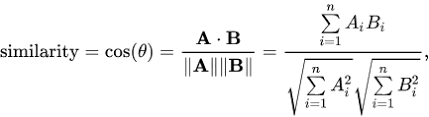

Más cerca de los vectores, más pequeño será el ángulo y más grande el coseno


In [22]:
# i. Usando el conteo de compras
name = 'cosine'
target = 'purchase_count'
cos = model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)
cos

Preparing data set.

Data has 197486 observations with 39019 users and 2257 items.

Data prepared in: 0.214396s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.659ms                        | 2.5        |

| 12.365ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 22.398ms                            | 0                | 0               |

| 135.696ms                           | 100              | 2257            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 1.16762s

recommendations finished on 1000/39037 queries. users per second: 33970.9

recommendations finished on 2000/39037 queries. users per second: 36531

recommendations finished on 3000/39037 queries. users per second: 37642.6

recommendations finished on 4000/39037 queries. users per second: 38086.9

recommendations finished on 5000/39037 queries. users per second: 38408.7

recommendations finished on 6000/39037 queries. users per second: 38554

recommendations finished on 7000/39037 queries. users per second: 38638.2

recommendations finished on 8000/39037 queries. users per second: 38693.7

recommendations finished on 9000/39037 queries. users per second: 38790.3

recommendations finished on 10000/39037 queries. users per second: 38912.3

recommendations finished on 11000/39037 queries. users per second: 38916.3

recommendations finished on 12000/39037 queries. users per second: 38817.1

recommendations finished on 13000/39037 queries. users per second: 38786.5

recommendations finished on 14000/39037 queries. users per second: 38828.8

recommendations finished on 15000/39037 queries. users per second: 38770.2

recommendations finished on 16000/39037 queries. users per second: 38769.8

recommendations finished on 17000/39037 queries. users per second: 38941.1

recommendations finished on 18000/39037 queries. users per second: 38954.3

recommendations finished on 19000/39037 queries. users per second: 38935.3

recommendations finished on 20000/39037 queries. users per second: 38992.4

recommendations finished on 21000/39037 queries. users per second: 39049.9

recommendations finished on 22000/39037 queries. users per second: 38768.9

recommendations finished on 23000/39037 queries. users per second: 38766.4

recommendations finished on 24000/39037 queries. users per second: 38776.5

recommendations finished on 25000/39037 queries. users per second: 38819.5

recommendations finished on 26000/39037 queries. users per second: 38772.1

recommendations finished on 27000/39037 queries. users per second: 38674.1

recommendations finished on 28000/39037 queries. users per second: 38791.2

recommendations finished on 29000/39037 queries. users per second: 38715.4

recommendations finished on 30000/39037 queries. users per second: 38738.5

recommendations finished on 31000/39037 queries. users per second: 38814.1

recommendations finished on 32000/39037 queries. users per second: 38828.8

recommendations finished on 33000/39037 queries. users per second: 38910.2

recommendations finished on 34000/39037 queries. users per second: 38928.3

recommendations finished on 35000/39037 queries. users per second: 38964.9

recommendations finished on 36000/39037 queries. users per second: 38973.6

recommendations finished on 37000/39037 queries. users per second: 38686.6

recommendations finished on 38000/39037 queries. users per second: 38518.3

recommendations finished on 39000/39037 queries. users per second: 38402.9

+------------+-----------+----------------------+------+
| customerId | productId |        score         | rank |
+------------+-----------+----------------------+------+
|     0      |    1485   | 0.09834958612918854  |  1   |
|     0      |    1488   | 0.07510887086391449  |  2   |
|     0      |    1483   | 0.06732180714607239  |  3   |
|     0      |    2613   | 0.06428401172161102  |  4   |
|     0      |    449    | 0.05813249945640564  |  5   |
|     0      |    1482   | 0.05463084578514099  |  6   |
|     0      |    1487   | 0.04139558970928192  |  7   |
|     0      |    2494   | 0.04111619293689728  |  8   |
|     0      |    1484   | 0.03186045587062836  |  9   |
|     0      |    2519   | 0.030281350016593933 |  10  |
|     2      |    1102   | 0.17433321475982666  |  1   |
|     2      |    447    | 0.12682161728541055  |  2   |
|     2      |    462    | 0.11564582586288452  |  3   |
|     2      |    813    | 0.10048749049504598  |  4   |
|     2      |    1101   | 0.09

Class                            : ItemSimilarityRecommender

Schema
------
User ID                          : customerId
Item ID                          : productId
Target                           : purchase_count
Additional observation features  : 0
User side features               : []
Item side features               : []

Statistics
----------
Number of observations           : 197486
Number of users                  : 39019
Number of items                  : 2257

Training summary
----------------
Training time                    : 1.1677

Model Parameters
----------------
Model class                      : ItemSimilarityRecommender
threshold                        : 0.001
similarity_type                  : cosine
training_method                  : auto

Other Settings
--------------
degree_approximation_threshold   : 4096
max_data_passes                  : 4096
max_item_neighborhood_size       : 64
nearest_neighbors_interaction_proportion_threshold : 0.05
seed_item_set_size   

In [23]:
# ii. Usando el dummy de compras
name = 'cosine'
target = 'purchase_dummy'
cos_dummy = model(train_data_dummy, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)
cos_dummy

Warning: Ignoring columns purchase_count;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 197486 observations with 39015 users and 2256 items.

Data prepared in: 0.216453s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 780us                          | 2.5        |

| 20.705ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 34.523ms                            | 0                | 0               |

| 142.69ms                            | 100              | 2256            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.170323s

recommendations finished on 1000/39037 queries. users per second: 34468.5

recommendations finished on 2000/39037 queries. users per second: 34626

recommendations finished on 3000/39037 queries. users per second: 36075.9

recommendations finished on 4000/39037 queries. users per second: 36843.3

recommendations finished on 5000/39037 queries. users per second: 37548

recommendations finished on 6000/39037 queries. users per second: 37152.6

recommendations finished on 7000/39037 queries. users per second: 37127

recommendations finished on 8000/39037 queries. users per second: 37468.1

recommendations finished on 9000/39037 queries. users per second: 37638.3

recommendations finished on 10000/39037 queries. users per second: 37911.4

recommendations finished on 11000/39037 queries. users per second: 38048.7

recommendations finished on 12000/39037 queries. users per second: 38272.1

recommendations finished on 13000/39037 queries. users per second: 38200.6

recommendations finished on 14000/39037 queries. users per second: 38078.7

recommendations finished on 15000/39037 queries. users per second: 38010

recommendations finished on 16000/39037 queries. users per second: 38081.5

recommendations finished on 17000/39037 queries. users per second: 38182.4

recommendations finished on 18000/39037 queries. users per second: 38285.5

recommendations finished on 19000/39037 queries. users per second: 38337.1

recommendations finished on 20000/39037 queries. users per second: 38413.2

recommendations finished on 21000/39037 queries. users per second: 38473.2

recommendations finished on 22000/39037 queries. users per second: 38587.1

recommendations finished on 23000/39037 queries. users per second: 38659.6

recommendations finished on 24000/39037 queries. users per second: 38719.9

recommendations finished on 25000/39037 queries. users per second: 38812.5

recommendations finished on 26000/39037 queries. users per second: 38839

recommendations finished on 27000/39037 queries. users per second: 38781.2

recommendations finished on 28000/39037 queries. users per second: 38847.4

recommendations finished on 29000/39037 queries. users per second: 38883.5

recommendations finished on 30000/39037 queries. users per second: 38829.2

recommendations finished on 31000/39037 queries. users per second: 38808.3

recommendations finished on 32000/39037 queries. users per second: 38839.5

recommendations finished on 33000/39037 queries. users per second: 38898.9

recommendations finished on 34000/39037 queries. users per second: 38942.1

recommendations finished on 35000/39037 queries. users per second: 38972.1

recommendations finished on 36000/39037 queries. users per second: 39051.6

recommendations finished on 37000/39037 queries. users per second: 39099.4

recommendations finished on 38000/39037 queries. users per second: 39134.5

recommendations finished on 39000/39037 queries. users per second: 39098.7

+------------+-----------+----------------------+------+
| customerId | productId |        score         | rank |
+------------+-----------+----------------------+------+
|     0      |    449    | 0.06875088214874267  |  1   |
|     0      |    1481   |  0.0593183159828186  |  2   |
|     0      |    1485   | 0.05345419645309448  |  3   |
|     0      |    2470   | 0.04444639682769776  |  4   |
|     0      |    2494   | 0.04078186750411987  |  5   |
|     0      |    1488   | 0.03972734212875366  |  6   |
|     0      |    1482   | 0.038307344913482665 |  7   |
|     0      |    615    | 0.03579730987548828  |  8   |
|     0      |    1483   | 0.034350454807281494 |  9   |
|     0      |    842    | 0.032827889919281004 |  10  |
|     2      |    447    | 0.11021105448404948  |  1   |
|     2      |    1102   | 0.09561467170715332  |  2   |
|     2      |    615    | 0.06772643327713013  |  3   |
|     2      |    813    | 0.06710286935170491  |  4   |
|     2      |    474    | 0.05

Class                            : ItemSimilarityRecommender

Schema
------
User ID                          : customerId
Item ID                          : productId
Target                           : purchase_dummy
Additional observation features  : 0
User side features               : []
Item side features               : []

Statistics
----------
Number of observations           : 197486
Number of users                  : 39015
Number of items                  : 2256

Training summary
----------------
Training time                    : 0.1704

Model Parameters
----------------
Model class                      : ItemSimilarityRecommender
threshold                        : 0.001
similarity_type                  : cosine
training_method                  : auto

Other Settings
--------------
degree_approximation_threshold   : 4096
max_data_passes                  : 4096
max_item_neighborhood_size       : 64
nearest_neighbors_interaction_proportion_threshold : 0.05
seed_item_set_size   

In [24]:
# iii. Uso del recuento de compras escalado
name = 'cosine' 
target = 'scaled_purchase_freq' 
cos_norm = model(train_data_norm, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)
cos_norm

Preparing data set.

Data has 162296 observations with 38802 users and 1619 items.

Data prepared in: 0.188261s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 801us                          | 2.5        |

| 19.226ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 21.894ms                            | 0                | 0               |

| 99.213ms                            | 100              | 1619            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.12092s

recommendations finished on 1000/39037 queries. users per second: 44551.4

recommendations finished on 2000/39037 queries. users per second: 48719.9

recommendations finished on 3000/39037 queries. users per second: 50660.3

recommendations finished on 4000/39037 queries. users per second: 51435

recommendations finished on 5000/39037 queries. users per second: 51793.6

recommendations finished on 6000/39037 queries. users per second: 52105

recommendations finished on 7000/39037 queries. users per second: 51912.6

recommendations finished on 8000/39037 queries. users per second: 52239.4

recommendations finished on 9000/39037 queries. users per second: 52375.5

recommendations finished on 10000/39037 queries. users per second: 52735.1

recommendations finished on 11000/39037 queries. users per second: 52817.1

recommendations finished on 12000/39037 queries. users per second: 52964.7

recommendations finished on 13000/39037 queries. users per second: 52663.1

recommendations finished on 14000/39037 queries. users per second: 52577

recommendations finished on 15000/39037 queries. users per second: 52439.7

recommendations finished on 16000/39037 queries. users per second: 52526.4

recommendations finished on 17000/39037 queries. users per second: 52589.7

recommendations finished on 18000/39037 queries. users per second: 52797.4

recommendations finished on 19000/39037 queries. users per second: 52504

recommendations finished on 20000/39037 queries. users per second: 52463.3

recommendations finished on 21000/39037 queries. users per second: 52271.6

recommendations finished on 22000/39037 queries. users per second: 52276.5

recommendations finished on 23000/39037 queries. users per second: 51944.6

recommendations finished on 24000/39037 queries. users per second: 51898.1

recommendations finished on 25000/39037 queries. users per second: 51903.7

recommendations finished on 26000/39037 queries. users per second: 51906.2

recommendations finished on 27000/39037 queries. users per second: 52019.5

recommendations finished on 28000/39037 queries. users per second: 51966.2

recommendations finished on 29000/39037 queries. users per second: 52033.2

recommendations finished on 30000/39037 queries. users per second: 52109.8

recommendations finished on 31000/39037 queries. users per second: 52130.6

recommendations finished on 32000/39037 queries. users per second: 52225.2

recommendations finished on 33000/39037 queries. users per second: 52289.7

recommendations finished on 34000/39037 queries. users per second: 52356.3

recommendations finished on 35000/39037 queries. users per second: 52439.1

recommendations finished on 36000/39037 queries. users per second: 52547.2

recommendations finished on 37000/39037 queries. users per second: 52505.2

recommendations finished on 38000/39037 queries. users per second: 52272

recommendations finished on 39000/39037 queries. users per second: 52164.4

+------------+-----------+----------------------+------+
| customerId | productId |        score         | rank |
+------------+-----------+----------------------+------+
|     0      |    2646   |         0.0          |  1   |
|     0      |    1588   |         0.0          |  2   |
|     0      |    2216   |         0.0          |  3   |
|     0      |    2035   |         0.0          |  4   |
|     0      |    214    |         0.0          |  5   |
|     0      |     42    |         0.0          |  6   |
|     0      |    916    |         0.0          |  7   |
|     0      |    1477   |         0.0          |  8   |
|     0      |    1029   |         0.0          |  9   |
|     0      |    144    |         0.0          |  10  |
|     2      |    1102   | 0.017420679330825806 |  1   |
|     2      |    1196   | 0.011894673109054565 |  2   |
|     2      |    1244   | 0.011443018913269043 |  3   |
|     2      |    462    | 0.010324537754058838 |  4   |
|     2      |    1574   | 0.01

Class                            : ItemSimilarityRecommender

Schema
------
User ID                          : customerId
Item ID                          : productId
Target                           : scaled_purchase_freq
Additional observation features  : 0
User side features               : []
Item side features               : []

Statistics
----------
Number of observations           : 162296
Number of users                  : 38802
Number of items                  : 1619

Training summary
----------------
Training time                    : 0.121

Model Parameters
----------------
Model class                      : ItemSimilarityRecommender
threshold                        : 0.001
similarity_type                  : cosine
training_method                  : auto

Other Settings
--------------
degree_approximation_threshold   : 4096
max_data_passes                  : 4096
max_item_neighborhood_size       : 64
nearest_neighbors_interaction_proportion_threshold : 0.05
seed_item_set_si

### 7.3. Pearson similarity

La similitud es el coeficiente de Pearson entre los dos vectores.
Se define por la siguiente fórmula
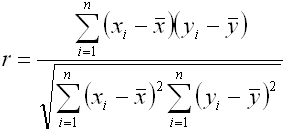

In [25]:
# i. Usando el conteo de compras
name = 'pearson'
target = 'purchase_count'
pear = model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)
pear

Preparing data set.

Data has 197486 observations with 39019 users and 2257 items.

Data prepared in: 0.218347s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.106ms                        | 2.5        |

| 22.553ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 30.544ms                            | 0                | 0               |

| 161.378ms                           | 100              | 2257            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.197762s

recommendations finished on 1000/39037 queries. users per second: 33835.2

recommendations finished on 2000/39037 queries. users per second: 36286.4

recommendations finished on 3000/39037 queries. users per second: 37072.3

recommendations finished on 4000/39037 queries. users per second: 37302.3

recommendations finished on 5000/39037 queries. users per second: 37812.3

recommendations finished on 6000/39037 queries. users per second: 37908.7

recommendations finished on 7000/39037 queries. users per second: 37849.1

recommendations finished on 8000/39037 queries. users per second: 37352.5

recommendations finished on 9000/39037 queries. users per second: 37146.8

recommendations finished on 10000/39037 queries. users per second: 37405.7

recommendations finished on 11000/39037 queries. users per second: 37557

recommendations finished on 12000/39037 queries. users per second: 37642.7

recommendations finished on 13000/39037 queries. users per second: 37626.1

recommendations finished on 14000/39037 queries. users per second: 37516.1

recommendations finished on 15000/39037 queries. users per second: 37608.8

recommendations finished on 16000/39037 queries. users per second: 37715.7

recommendations finished on 17000/39037 queries. users per second: 37728

recommendations finished on 18000/39037 queries. users per second: 37801.1

recommendations finished on 19000/39037 queries. users per second: 37838.7

recommendations finished on 20000/39037 queries. users per second: 37783.4

recommendations finished on 21000/39037 queries. users per second: 37690.3

recommendations finished on 22000/39037 queries. users per second: 37629.4

recommendations finished on 23000/39037 queries. users per second: 37745.6

recommendations finished on 24000/39037 queries. users per second: 37662.2

recommendations finished on 25000/39037 queries. users per second: 37728.6

recommendations finished on 26000/39037 queries. users per second: 37786.4

recommendations finished on 27000/39037 queries. users per second: 37641.5

recommendations finished on 28000/39037 queries. users per second: 37735.1

recommendations finished on 29000/39037 queries. users per second: 37782.9

recommendations finished on 30000/39037 queries. users per second: 37840.4

recommendations finished on 31000/39037 queries. users per second: 37893.7

recommendations finished on 32000/39037 queries. users per second: 37871.4

recommendations finished on 33000/39037 queries. users per second: 37952.3

recommendations finished on 34000/39037 queries. users per second: 37986

recommendations finished on 35000/39037 queries. users per second: 38030.9

recommendations finished on 36000/39037 queries. users per second: 38047

recommendations finished on 37000/39037 queries. users per second: 38076.1

recommendations finished on 38000/39037 queries. users per second: 38113

recommendations finished on 39000/39037 queries. users per second: 37999.8

+------------+-----------+--------------------+------+
| customerId | productId |       score        | rank |
+------------+-----------+--------------------+------+
|     0      |    1160   | 7.333333333333334  |  1   |
|     0      |    585    |        6.0         |  2   |
|     0      |    2292   |        6.0         |  3   |
|     0      |    588    | 4.666666666666667  |  4   |
|     0      |    607    | 4.428571428571429  |  5   |
|     0      |    596    |        4.0         |  6   |
|     0      |    1005   |        4.0         |  7   |
|     0      |    1109   |        4.0         |  8   |
|     0      |    1108   |        4.0         |  9   |
|     0      |    1769   | 3.7333333333333334 |  10  |
|     2      |    1160   | 7.333333333333334  |  1   |
|     2      |    585    |        6.0         |  2   |
|     2      |    2292   |        6.0         |  3   |
|     2      |    588    | 4.666666666666667  |  4   |
|     2      |    607    | 4.428571428571429  |  5   |
|     2   

Class                            : ItemSimilarityRecommender

Schema
------
User ID                          : customerId
Item ID                          : productId
Target                           : purchase_count
Additional observation features  : 0
User side features               : []
Item side features               : []

Statistics
----------
Number of observations           : 197486
Number of users                  : 39019
Number of items                  : 2257

Training summary
----------------
Training time                    : 0.1978

Model Parameters
----------------
Model class                      : ItemSimilarityRecommender
threshold                        : 0.001
similarity_type                  : pearson
training_method                  : auto

Other Settings
--------------
degree_approximation_threshold   : 4096
max_data_passes                  : 4096
max_item_neighborhood_size       : 64
nearest_neighbors_interaction_proportion_threshold : 0.05
seed_item_set_size  

In [26]:
# ii. Usando el dummy de compras
name = 'pearson'
target = 'purchase_dummy'
pear_dummy = model(train_data_dummy, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)
pear_dummy

Warning: Ignoring columns purchase_count;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 197486 observations with 39015 users and 2256 items.

Data prepared in: 0.220467s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.753ms                        | 2.5        |

| 25.555ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 30.472ms                            | 0                | 0               |

| 131.574ms                           | 100              | 2256            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.155351s

recommendations finished on 1000/39037 queries. users per second: 27626.6

recommendations finished on 2000/39037 queries. users per second: 29052

recommendations finished on 3000/39037 queries. users per second: 29668.3

recommendations finished on 4000/39037 queries. users per second: 28965.8

recommendations finished on 5000/39037 queries. users per second: 29315.5

recommendations finished on 6000/39037 queries. users per second: 29524.1

recommendations finished on 7000/39037 queries. users per second: 29408.8

recommendations finished on 8000/39037 queries. users per second: 29562.6

recommendations finished on 9000/39037 queries. users per second: 29250.2

recommendations finished on 10000/39037 queries. users per second: 29213.7

recommendations finished on 11000/39037 queries. users per second: 29329.7

recommendations finished on 12000/39037 queries. users per second: 29453.1

recommendations finished on 13000/39037 queries. users per second: 29530.5

recommendations finished on 14000/39037 queries. users per second: 29454

recommendations finished on 15000/39037 queries. users per second: 29569.2

recommendations finished on 16000/39037 queries. users per second: 29509.2

recommendations finished on 17000/39037 queries. users per second: 29557.9

recommendations finished on 18000/39037 queries. users per second: 29620.3

recommendations finished on 19000/39037 queries. users per second: 29660.9

recommendations finished on 20000/39037 queries. users per second: 29658

recommendations finished on 21000/39037 queries. users per second: 29749.1

recommendations finished on 22000/39037 queries. users per second: 29785.1

recommendations finished on 23000/39037 queries. users per second: 29832.7

recommendations finished on 24000/39037 queries. users per second: 29871.4

recommendations finished on 25000/39037 queries. users per second: 29910.1

recommendations finished on 26000/39037 queries. users per second: 29935.2

recommendations finished on 27000/39037 queries. users per second: 29842

recommendations finished on 28000/39037 queries. users per second: 29885.5

recommendations finished on 29000/39037 queries. users per second: 29919.3

recommendations finished on 30000/39037 queries. users per second: 29950.5

recommendations finished on 31000/39037 queries. users per second: 29975.6

recommendations finished on 32000/39037 queries. users per second: 29979.8

recommendations finished on 33000/39037 queries. users per second: 30010

recommendations finished on 34000/39037 queries. users per second: 30060.5

recommendations finished on 35000/39037 queries. users per second: 30088.3

recommendations finished on 36000/39037 queries. users per second: 30108.5

recommendations finished on 37000/39037 queries. users per second: 30039.6

recommendations finished on 38000/39037 queries. users per second: 30058

recommendations finished on 39000/39037 queries. users per second: 30018.4

+------------+-----------+-------+------+
| customerId | productId | score | rank |
+------------+-----------+-------+------+
|     0      |    2215   |  0.0  |  1   |
|     0      |    1492   |  0.0  |  2   |
|     0      |    2415   |  0.0  |  3   |
|     0      |    462    |  0.0  |  4   |
|     0      |    1475   |  0.0  |  5   |
|     0      |    601    |  0.0  |  6   |
|     0      |    1817   |  0.0  |  7   |
|     0      |    474    |  0.0  |  8   |
|     0      |    2037   |  0.0  |  9   |
|     0      |    926    |  0.0  |  10  |
|     2      |    2215   |  0.0  |  1   |
|     2      |    1492   |  0.0  |  2   |
|     2      |    2415   |  0.0  |  3   |
|     2      |    462    |  0.0  |  4   |
|     2      |    1475   |  0.0  |  5   |
|     2      |    601    |  0.0  |  6   |
|     2      |    1817   |  0.0  |  7   |
|     2      |    474    |  0.0  |  8   |
|     2      |    2037   |  0.0  |  9   |
|     2      |    926    |  0.0  |  10  |
|     5      |     90    |  0.0  |

Class                            : ItemSimilarityRecommender

Schema
------
User ID                          : customerId
Item ID                          : productId
Target                           : purchase_dummy
Additional observation features  : 0
User side features               : []
Item side features               : []

Statistics
----------
Number of observations           : 197486
Number of users                  : 39015
Number of items                  : 2256

Training summary
----------------
Training time                    : 0.1554

Model Parameters
----------------
Model class                      : ItemSimilarityRecommender
threshold                        : 0.001
similarity_type                  : pearson
training_method                  : auto

Other Settings
--------------
degree_approximation_threshold   : 4096
max_data_passes                  : 4096
max_item_neighborhood_size       : 64
nearest_neighbors_interaction_proportion_threshold : 0.05
seed_item_set_size  

In [27]:
# iii. Uso del recuento de compras escalado
name = 'pearson'
target = 'scaled_purchase_freq'
pear_norm = model(train_data_norm, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)
pear_norm

Preparing data set.

Data has 162296 observations with 38802 users and 1619 items.

Data prepared in: 0.192961s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.019ms                        | 2.5        |

| 30.603ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 38.429ms                            | 0                | 0               |

| 138.067ms                           | 100              | 1619            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.163751s

recommendations finished on 1000/39037 queries. users per second: 40480.9

recommendations finished on 2000/39037 queries. users per second: 43795.3

recommendations finished on 3000/39037 queries. users per second: 45216.1

recommendations finished on 4000/39037 queries. users per second: 45923.2

recommendations finished on 5000/39037 queries. users per second: 46258.6

recommendations finished on 6000/39037 queries. users per second: 46434.6

recommendations finished on 7000/39037 queries. users per second: 46369.3

recommendations finished on 8000/39037 queries. users per second: 46579.9

recommendations finished on 9000/39037 queries. users per second: 46979.2

recommendations finished on 10000/39037 queries. users per second: 47077.4

recommendations finished on 11000/39037 queries. users per second: 47156.1

recommendations finished on 12000/39037 queries. users per second: 47300.1

recommendations finished on 13000/39037 queries. users per second: 47123.5

recommendations finished on 14000/39037 queries. users per second: 47004.8

recommendations finished on 15000/39037 queries. users per second: 47136.9

recommendations finished on 16000/39037 queries. users per second: 47107.5

recommendations finished on 17000/39037 queries. users per second: 47142.7

recommendations finished on 18000/39037 queries. users per second: 47229.1

recommendations finished on 19000/39037 queries. users per second: 47324.7

recommendations finished on 20000/39037 queries. users per second: 47319.9

recommendations finished on 21000/39037 queries. users per second: 47357.7

recommendations finished on 22000/39037 queries. users per second: 47417.7

recommendations finished on 23000/39037 queries. users per second: 47473.7

recommendations finished on 24000/39037 queries. users per second: 47582.3

recommendations finished on 25000/39037 queries. users per second: 47601

recommendations finished on 26000/39037 queries. users per second: 47501

recommendations finished on 27000/39037 queries. users per second: 47525.4

recommendations finished on 28000/39037 queries. users per second: 47172.6

recommendations finished on 29000/39037 queries. users per second: 47265.8

recommendations finished on 30000/39037 queries. users per second: 47298.8

recommendations finished on 31000/39037 queries. users per second: 47147.1

recommendations finished on 32000/39037 queries. users per second: 47153.3

recommendations finished on 33000/39037 queries. users per second: 47244.2

recommendations finished on 34000/39037 queries. users per second: 47296.1

recommendations finished on 35000/39037 queries. users per second: 47337

recommendations finished on 36000/39037 queries. users per second: 47382.1

recommendations finished on 37000/39037 queries. users per second: 47429.6

recommendations finished on 38000/39037 queries. users per second: 47336

recommendations finished on 39000/39037 queries. users per second: 47138.1

+------------+-----------+--------------------+------+
| customerId | productId |       score        | rank |
+------------+-----------+--------------------+------+
|     0      |    2705   |        1.0         |  1   |
|     0      |    2766   |        1.0         |  2   |
|     0      |    2505   |        1.0         |  3   |
|     0      |    2710   |        1.0         |  4   |
|     0      |    1316   |        1.0         |  5   |
|     0      |    923    | 0.9444444444444444 |  6   |
|     0      |    1500   | 0.7999468525250754 |  7   |
|     0      |    1324   | 0.7631566430393019 |  8   |
|     0      |    2250   |        0.75        |  9   |
|     0      |    1507   |        0.75        |  10  |
|     2      |    2705   |        1.0         |  1   |
|     2      |    2766   |        1.0         |  2   |
|     2      |    2505   |        1.0         |  3   |
|     2      |    2710   |        1.0         |  4   |
|     2      |    1316   |        1.0         |  5   |
|     2   

Class                            : ItemSimilarityRecommender

Schema
------
User ID                          : customerId
Item ID                          : productId
Target                           : scaled_purchase_freq
Additional observation features  : 0
User side features               : []
Item side features               : []

Statistics
----------
Number of observations           : 162296
Number of users                  : 38802
Number of items                  : 1619

Training summary
----------------
Training time                    : 0.1638

Model Parameters
----------------
Model class                      : ItemSimilarityRecommender
threshold                        : 0.001
similarity_type                  : pearson
training_method                  : auto

Other Settings
--------------
degree_approximation_threshold   : 4096
max_data_passes                  : 4096
max_item_neighborhood_size       : 64
nearest_neighbors_interaction_proportion_threshold : 0.05
seed_item_set_

## 8. Evaluación del modelo

Para evaluar los motores de recomendación, podemos usar el concepto de RMSE y la recuperación de precisión.

1. RMSE (errores cuadráticos medios de raíz)
Mide el error de los valores pronosticados.
Menor el valor RMSE, mejores las recomendaciones.

2. Recordar
 ¿Qué porcentaje de productos que compra un usuario se recomiendan realmente?
Si un cliente compra 5 productos y la recomendación decidió mostrar 3 de ellos, entonces el retiro es 0.6

3. Precisión
De todos los elementos recomendados, ¿cuántos le gustaron realmente al usuario?
Si se recomendaron al cliente 5 productos de los cuales compra 4, entonces la precisión es 0.8
¿Por qué son importantes tanto el recuerdo como la precisión?
Considere un caso en el que recomendamos todos los productos, por lo que nuestros clientes seguramente cubrirán los artículos que les gustaron y compraron. ¡En este caso, tenemos un 100% de retiro! ¿Esto significa que nuestro modelo es bueno?
Tenemos que considerar la precisión. Si recomendamos 300 artículos pero al usuario le gusta y compra solo 3 de ellos, ¡la precisión es del 0.1%! Esta precisión muy baja indica que el modelo no es excelente, a pesar de su excelente recuperación.
Por lo tanto, nuestro objetivo debe ser optimizar tanto el recuerdo como la precisión (para estar lo más cerca posible de 1).

In [0]:
# Primero creemos variables invocables iniciales para la evaluación del modelo:
models_w_counts = [popularity, cos, pear]
models_w_dummy = [pop_dummy, cos_dummy, pear_dummy]
models_w_norm = [pop_norm, cos_norm, pear_norm]

names_w_counts = ['Popularity Model on Purchase Counts', 'Cosine Similarity on Purchase Counts',\
                  'Pearson Similarity on Purchase Counts']
names_w_dummy = ['Popularity Model on Purchase Dummy', 'Cosine Similarity on Purchase Dummy',\
                 'Pearson Similarity on Purchase Dummy']
names_w_norm = ['Popularity Model on Scaled Purchase Counts', 'Cosine Similarity on Scaled Purchase Counts',\
                'Pearson Similarity on Scaled Purchase Counts']

## 8.1. Resultado de evaluación

In [0]:
#### Comparemos todos los modelos que hemos construido basados en RMSE y características de recuperación de precisión:

In [30]:
eval_counts = tc.recommender.util.compare_models(test_data, models_w_counts, model_names=names_w_counts)

PROGRESS: Evaluate model Popularity Model on Purchase Counts


recommendations finished on 1000/27710 queries. users per second: 24750

recommendations finished on 2000/27710 queries. users per second: 25067.7

recommendations finished on 3000/27710 queries. users per second: 25423.7

recommendations finished on 4000/27710 queries. users per second: 25940.2

recommendations finished on 5000/27710 queries. users per second: 26315

recommendations finished on 6000/27710 queries. users per second: 25948

recommendations finished on 7000/27710 queries. users per second: 25819.9

recommendations finished on 8000/27710 queries. users per second: 26091.4

recommendations finished on 9000/27710 queries. users per second: 26048.1

recommendations finished on 10000/27710 queries. users per second: 26100.3

recommendations finished on 11000/27710 queries. users per second: 25990

recommendations finished on 12000/27710 queries. users per second: 25752.7

recommendations finished on 13000/27710 queries. users per second: 25709.1

recommendations finished on 14000/27710 queries. users per second: 25865.1

recommendations finished on 15000/27710 queries. users per second: 25998.9

recommendations finished on 16000/27710 queries. users per second: 26113.6

recommendations finished on 17000/27710 queries. users per second: 26224

recommendations finished on 18000/27710 queries. users per second: 26167.5

recommendations finished on 19000/27710 queries. users per second: 26152.5

recommendations finished on 20000/27710 queries. users per second: 26217.9

recommendations finished on 21000/27710 queries. users per second: 26303.5

recommendations finished on 22000/27710 queries. users per second: 26381.1

recommendations finished on 23000/27710 queries. users per second: 26266.9

recommendations finished on 24000/27710 queries. users per second: 26109.7

recommendations finished on 25000/27710 queries. users per second: 26145.6

recommendations finished on 26000/27710 queries. users per second: 26206.7

recommendations finished on 27000/27710 queries. users per second: 26238.5


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    |          0.0           |          0.0           |
|   2    |          0.0           |          0.0           |
|   3    | 1.202935161794771e-05  | 1.804402742692161e-05  |
|   4    | 1.8044027426921644e-05 | 2.7066041140382474e-05 |
|   5    | 2.8870443883074587e-05 | 4.009783872649303e-05  |
|   6    | 3.007337904486936e-05  | 5.814186615341492e-05  |
|   7    | 2.5777182038459882e-05 | 5.814186615341492e-05  |
|   8    | 2.7066041140382453e-05 | 7.618589358033522e-05  |
|   9    | 2.4058703235895398e-05 | 7.618589358033522e-05  |
|   10   | 4.691447130999609e-05  | 0.00020850876137776226 |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.5092568920853667

Per User RMSE (best)
+------------+--

recommendations finished on 1000/27710 queries. users per second: 24959.4

recommendations finished on 2000/27710 queries. users per second: 24231

recommendations finished on 3000/27710 queries. users per second: 24113.8

recommendations finished on 4000/27710 queries. users per second: 24693.8

recommendations finished on 5000/27710 queries. users per second: 24970

recommendations finished on 6000/27710 queries. users per second: 24755.9

recommendations finished on 7000/27710 queries. users per second: 24650.4

recommendations finished on 8000/27710 queries. users per second: 24873.6

recommendations finished on 9000/27710 queries. users per second: 24938.8

recommendations finished on 10000/27710 queries. users per second: 25110.4

recommendations finished on 11000/27710 queries. users per second: 25246.1

recommendations finished on 12000/27710 queries. users per second: 25169

recommendations finished on 13000/27710 queries. users per second: 25264.3

recommendations finished on 14000/27710 queries. users per second: 25339.2

recommendations finished on 15000/27710 queries. users per second: 25433.3

recommendations finished on 16000/27710 queries. users per second: 25456.1

recommendations finished on 17000/27710 queries. users per second: 25461.9

recommendations finished on 18000/27710 queries. users per second: 25540.8

recommendations finished on 19000/27710 queries. users per second: 25403.7

recommendations finished on 20000/27710 queries. users per second: 25454.9

recommendations finished on 21000/27710 queries. users per second: 25274.9

recommendations finished on 22000/27710 queries. users per second: 25317

recommendations finished on 23000/27710 queries. users per second: 25369.8

recommendations finished on 24000/27710 queries. users per second: 25360.9

recommendations finished on 25000/27710 queries. users per second: 25388.6

recommendations finished on 26000/27710 queries. users per second: 25323.8

recommendations finished on 27000/27710 queries. users per second: 25365.7


Precision and recall summary statistics by cutoff
+--------+----------------------+----------------------+
| cutoff |    mean_precision    |     mean_recall      |
+--------+----------------------+----------------------+
|   1    | 0.06257668711656425  | 0.038870990671784726 |
|   2    | 0.049494767232046065 | 0.060777057058182676 |
|   3    | 0.04198243714663773  | 0.07752174266248603  |
|   4    | 0.037224828581739484 |  0.0921056286429798  |
|   5    | 0.03380007217610957  | 0.10439181726447429  |
|   6    | 0.03113797666305804  | 0.11540935974002142  |
|   7    | 0.028901376501520883 | 0.12478565999055492  |
|   8    | 0.027106640202093003 |  0.1337125272609809  |
|   9    | 0.025558362404266472 |  0.141131804322986   |
|   10   | 0.02421147600144354  | 0.14817249920290812  |
+--------+----------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.3099848081726708

Per User RMSE (best)
+------------+--------------------+-------+
| customerId |        rmse  

recommendations finished on 1000/27710 queries. users per second: 20287.3

recommendations finished on 2000/27710 queries. users per second: 20161.3

recommendations finished on 3000/27710 queries. users per second: 20398.3

recommendations finished on 4000/27710 queries. users per second: 20832.2

recommendations finished on 5000/27710 queries. users per second: 21032.9

recommendations finished on 6000/27710 queries. users per second: 20791.2

recommendations finished on 7000/27710 queries. users per second: 20721.3

recommendations finished on 8000/27710 queries. users per second: 20956

recommendations finished on 9000/27710 queries. users per second: 21011

recommendations finished on 10000/27710 queries. users per second: 20959.5

recommendations finished on 11000/27710 queries. users per second: 20988.2

recommendations finished on 12000/27710 queries. users per second: 20897.3

recommendations finished on 13000/27710 queries. users per second: 20998.3

recommendations finished on 14000/27710 queries. users per second: 21062.4

recommendations finished on 15000/27710 queries. users per second: 21070.3

recommendations finished on 16000/27710 queries. users per second: 21097.5

recommendations finished on 17000/27710 queries. users per second: 21161.8

recommendations finished on 18000/27710 queries. users per second: 21126.4

recommendations finished on 19000/27710 queries. users per second: 21179.9

recommendations finished on 20000/27710 queries. users per second: 21165.2

recommendations finished on 21000/27710 queries. users per second: 21212.2

recommendations finished on 22000/27710 queries. users per second: 21245

recommendations finished on 23000/27710 queries. users per second: 21235.8

recommendations finished on 24000/27710 queries. users per second: 21216.4

recommendations finished on 25000/27710 queries. users per second: 21253.8

recommendations finished on 26000/27710 queries. users per second: 21294.5

recommendations finished on 27000/27710 queries. users per second: 21328.1


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    |          0.0           |          0.0           |
|   2    | 1.8044027426921623e-05 | 1.8044027426921623e-05 |
|   3    | 1.2029351617947708e-05 | 1.8044027426921623e-05 |
|   4    | 1.8044027426921644e-05 | 2.7066041140382504e-05 |
|   5    | 2.8870443883074587e-05 | 4.009783872649303e-05  |
|   6    | 3.007337904486936e-05  | 5.814186615341492e-05  |
|   7    | 3.0932618446151706e-05 |  7.61858935803352e-05  |
|   8    | 2.7066041140382453e-05 |  7.61858935803352e-05  |
|   9    | 2.4058703235895405e-05 |  7.61858935803352e-05  |
|   10   | 3.969686033922788e-05  | 0.00021151609928224874 |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.5073068055253008

Per User RMSE (best)
+------------+--

In [31]:
eval_dummy = tc.recommender.util.compare_models(test_data_dummy, models_w_dummy, model_names=names_w_dummy)

PROGRESS: Evaluate model Popularity Model on Purchase Dummy


recommendations finished on 1000/27766 queries. users per second: 34040.2

recommendations finished on 2000/27766 queries. users per second: 35244.2

recommendations finished on 3000/27766 queries. users per second: 35884.7

recommendations finished on 4000/27766 queries. users per second: 37376.9

recommendations finished on 5000/27766 queries. users per second: 38227.8

recommendations finished on 6000/27766 queries. users per second: 37204.7

recommendations finished on 7000/27766 queries. users per second: 37709.6

recommendations finished on 8000/27766 queries. users per second: 37359.6

recommendations finished on 9000/27766 queries. users per second: 37868.4

recommendations finished on 10000/27766 queries. users per second: 38304.5

recommendations finished on 11000/27766 queries. users per second: 38656.9

recommendations finished on 12000/27766 queries. users per second: 37879.7

recommendations finished on 13000/27766 queries. users per second: 37842.1

recommendations finished on 14000/27766 queries. users per second: 38003.3

recommendations finished on 15000/27766 queries. users per second: 38214.4

recommendations finished on 16000/27766 queries. users per second: 38414.3

recommendations finished on 17000/27766 queries. users per second: 38639.3

recommendations finished on 18000/27766 queries. users per second: 38704.1

recommendations finished on 19000/27766 queries. users per second: 38134.4

recommendations finished on 20000/27766 queries. users per second: 38000.6

recommendations finished on 21000/27766 queries. users per second: 37984.6

recommendations finished on 22000/27766 queries. users per second: 37205.3

recommendations finished on 23000/27766 queries. users per second: 37293.1

recommendations finished on 24000/27766 queries. users per second: 36926.7

recommendations finished on 25000/27766 queries. users per second: 37086.6

recommendations finished on 26000/27766 queries. users per second: 37121.5

recommendations finished on 27000/27766 queries. users per second: 37216.3


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    | 0.00018007635237340545 | 0.0001320559917404977  |
|   2    | 0.0001620687171360665  | 0.00019208144253163404 |
|   3    | 0.00018007635237340548 | 0.0003631539772863697  |
|   4    | 0.00015306489951739594 | 0.00039916924776104844 |
|   5    | 0.00015126413599366104 | 0.0004463321019540855  |
|   6    | 0.00014406108189872604 | 0.0004823473724287649  |
|   7    | 0.00012862596598100514 | 0.0004913511900474353  |
|   8    | 0.00012605344666138496 | 0.0005285669695379425  |
|   9    | 0.00013605768845990728 | 0.0006846331415948925  |
|   10   | 0.0001368580278037899  |  0.000765667500162926  |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.0

Per User RMSE (best)
+------------+------+-------+
|

recommendations finished on 1000/27766 queries. users per second: 23485.2

recommendations finished on 2000/27766 queries. users per second: 23867.8

recommendations finished on 3000/27766 queries. users per second: 24560.2

recommendations finished on 4000/27766 queries. users per second: 24884.4

recommendations finished on 5000/27766 queries. users per second: 25181.9

recommendations finished on 6000/27766 queries. users per second: 25049.6

recommendations finished on 7000/27766 queries. users per second: 25065.5

recommendations finished on 8000/27766 queries. users per second: 25067.8

recommendations finished on 9000/27766 queries. users per second: 25304.1

recommendations finished on 10000/27766 queries. users per second: 25445.9

recommendations finished on 11000/27766 queries. users per second: 25569.3

recommendations finished on 12000/27766 queries. users per second: 25699

recommendations finished on 13000/27766 queries. users per second: 25533.3

recommendations finished on 14000/27766 queries. users per second: 25456.4

recommendations finished on 15000/27766 queries. users per second: 25454.6

recommendations finished on 16000/27766 queries. users per second: 25530.8

recommendations finished on 17000/27766 queries. users per second: 25612.5

recommendations finished on 18000/27766 queries. users per second: 25622

recommendations finished on 19000/27766 queries. users per second: 25585.4

recommendations finished on 20000/27766 queries. users per second: 25607.4

recommendations finished on 21000/27766 queries. users per second: 25665.7

recommendations finished on 22000/27766 queries. users per second: 25685.9

recommendations finished on 23000/27766 queries. users per second: 25684.7

recommendations finished on 24000/27766 queries. users per second: 25745.4

recommendations finished on 25000/27766 queries. users per second: 25662.1

recommendations finished on 26000/27766 queries. users per second: 25696

recommendations finished on 27000/27766 queries. users per second: 25484.8


Precision and recall summary statistics by cutoff
+--------+----------------------+----------------------+
| cutoff |    mean_precision    |     mean_recall      |
+--------+----------------------+----------------------+
|   1    |  0.0747677015054382  | 0.046768611059920424 |
|   2    | 0.059929410069869744 | 0.07471108854050264  |
|   3    | 0.05124972988547161  | 0.09564545945061086  |
|   4    | 0.04536123316286117  | 0.11209824971939862  |
|   5    | 0.04097097169199697  | 0.12580529137519114  |
|   6    | 0.03767797546159581  |  0.1391488633354173  |
|   7    |  0.0346106749261685  | 0.14900650011626712  |
|   8    |  0.0322831880717423  |  0.1585900778389377  |
|   9    | 0.03033286113312051  | 0.16701680791534534  |
|   10   | 0.02863574155441901  | 0.17510206463562572  |
+--------+----------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.9849732205561309

Per User RMSE (best)
+------------+---------------------+-------+
| customerId |         rmse

recommendations finished on 1000/27766 queries. users per second: 23002.3

recommendations finished on 2000/27766 queries. users per second: 22305.7

recommendations finished on 3000/27766 queries. users per second: 23181.2

recommendations finished on 4000/27766 queries. users per second: 23553

recommendations finished on 5000/27766 queries. users per second: 24036.7

recommendations finished on 6000/27766 queries. users per second: 24094.5

recommendations finished on 7000/27766 queries. users per second: 23906.8

recommendations finished on 8000/27766 queries. users per second: 23815.8

recommendations finished on 9000/27766 queries. users per second: 23993.4

recommendations finished on 10000/27766 queries. users per second: 24197.4

recommendations finished on 11000/27766 queries. users per second: 24356.4

recommendations finished on 12000/27766 queries. users per second: 24414.4

recommendations finished on 13000/27766 queries. users per second: 24079.1

recommendations finished on 14000/27766 queries. users per second: 24215.1

recommendations finished on 15000/27766 queries. users per second: 24348.2

recommendations finished on 16000/27766 queries. users per second: 24357

recommendations finished on 17000/27766 queries. users per second: 24398.8

recommendations finished on 18000/27766 queries. users per second: 24442.9

recommendations finished on 19000/27766 queries. users per second: 24333

recommendations finished on 20000/27766 queries. users per second: 24423.5

recommendations finished on 21000/27766 queries. users per second: 24506.4

recommendations finished on 22000/27766 queries. users per second: 24579.2

recommendations finished on 23000/27766 queries. users per second: 24481.6

recommendations finished on 24000/27766 queries. users per second: 24547.8

recommendations finished on 25000/27766 queries. users per second: 24327.6

recommendations finished on 26000/27766 queries. users per second: 24354.4

recommendations finished on 27000/27766 queries. users per second: 24315.3


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    | 0.00018007635237340556 | 0.0001320559917404977  |
|   2    | 0.0001620687171360666  | 0.00019208144253163393 |
|   3    | 0.00018007635237340537 | 0.0003631539772863691  |
|   4    | 0.0001530648995173963  | 0.00039916924776104947 |
|   5    | 0.00015126413599366088 | 0.00044633210195408604 |
|   6    | 0.00014406108189872618 | 0.00048234737242876534 |
|   7    | 0.00012862596598100525 | 0.0004913511900474357  |
|   8    | 0.00012605344666138477 |  0.000528566969537943  |
|   9    | 0.00013605768845990687 | 0.0006846331415948929  |
|   10   | 0.00013685802780379077 | 0.0007656675001629252  |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0

Per User RMSE (best)
+------------+------+-------+
|

In [32]:
eval_norm = tc.recommender.util.compare_models(test_data_norm, models_w_norm, model_names=names_w_norm)

PROGRESS: Evaluate model Popularity Model on Scaled Purchase Counts


recommendations finished on 1000/24896 queries. users per second: 30910.9

recommendations finished on 2000/24896 queries. users per second: 31280.3

recommendations finished on 3000/24896 queries. users per second: 32459.1

recommendations finished on 4000/24896 queries. users per second: 32470.7

recommendations finished on 5000/24896 queries. users per second: 33005.9

recommendations finished on 6000/24896 queries. users per second: 33007.7

recommendations finished on 7000/24896 queries. users per second: 32858.5

recommendations finished on 8000/24896 queries. users per second: 31892.5

recommendations finished on 9000/24896 queries. users per second: 32282

recommendations finished on 10000/24896 queries. users per second: 32626.5

recommendations finished on 11000/24896 queries. users per second: 32512.9

recommendations finished on 12000/24896 queries. users per second: 32723.1

recommendations finished on 13000/24896 queries. users per second: 32494.7

recommendations finished on 14000/24896 queries. users per second: 32579.7

recommendations finished on 15000/24896 queries. users per second: 32859.5

recommendations finished on 16000/24896 queries. users per second: 32983.9

recommendations finished on 17000/24896 queries. users per second: 33016.3

recommendations finished on 18000/24896 queries. users per second: 32864.5

recommendations finished on 19000/24896 queries. users per second: 33035.8

recommendations finished on 20000/24896 queries. users per second: 33152.4

recommendations finished on 21000/24896 queries. users per second: 33296.5

recommendations finished on 22000/24896 queries. users per second: 33243

recommendations finished on 23000/24896 queries. users per second: 33130

recommendations finished on 24000/24896 queries. users per second: 32411.8


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    | 0.00012050128534704375 | 7.029241645244174e-05  |
|   2    | 0.00010041773778920306 |  9.17148671808055e-05  |
|   3    | 6.694515852613504e-05  |  9.17148671808055e-05  |
|   4    | 5.020886889460153e-05  |  9.17148671808055e-05  |
|   5    | 4.820051413881787e-05  | 0.0001318819622964865  |
|   6    | 4.686161096829482e-05  | 0.0001363449728648958  |
|   7    | 5.164340800587602e-05  | 0.00016981755212796363 |
|   8    | 9.539685089974318e-05  | 0.00037371337781042256 |
|   9    | 8.479720079977193e-05  | 0.00037371337781042245 |
|   10   | 8.033419023136291e-05  | 0.00039379692536826007 |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.1683386116177798

Per User RMSE (best)
+------------+--

recommendations finished on 1000/24896 queries. users per second: 33661

recommendations finished on 2000/24896 queries. users per second: 33963.4

recommendations finished on 3000/24896 queries. users per second: 34804.8

recommendations finished on 4000/24896 queries. users per second: 35409.2

recommendations finished on 5000/24896 queries. users per second: 35617.1

recommendations finished on 6000/24896 queries. users per second: 35588.7

recommendations finished on 7000/24896 queries. users per second: 35711.4

recommendations finished on 8000/24896 queries. users per second: 35975.4

recommendations finished on 9000/24896 queries. users per second: 36074.9

recommendations finished on 10000/24896 queries. users per second: 36317

recommendations finished on 11000/24896 queries. users per second: 36474.6

recommendations finished on 12000/24896 queries. users per second: 36223.8

recommendations finished on 13000/24896 queries. users per second: 36434.4

recommendations finished on 14000/24896 queries. users per second: 36677.3

recommendations finished on 15000/24896 queries. users per second: 36666.3

recommendations finished on 16000/24896 queries. users per second: 36816.2

recommendations finished on 17000/24896 queries. users per second: 36903.7

recommendations finished on 18000/24896 queries. users per second: 37071

recommendations finished on 19000/24896 queries. users per second: 37046.8

recommendations finished on 20000/24896 queries. users per second: 36928.9

recommendations finished on 21000/24896 queries. users per second: 37111.3

recommendations finished on 22000/24896 queries. users per second: 37142.2

recommendations finished on 23000/24896 queries. users per second: 37059.8

recommendations finished on 24000/24896 queries. users per second: 37123.6


Precision and recall summary statistics by cutoff
+--------+-----------------------+----------------------+
| cutoff |     mean_precision    |     mean_recall      |
+--------+-----------------------+----------------------+
|   1    |  0.007149742930591267 | 0.004853858718937477 |
|   2    |  0.005281973007712073 | 0.006965420594115968 |
|   3    |  0.004739717223650379 | 0.009345320979720049 |
|   4    |  0.004368171593830319 | 0.011436353006283916 |
|   5    |  0.004233611825192829 | 0.013751364406088082 |
|   6    |  0.004043487574978601 |  0.0156596839678459  |
|   7    | 0.0039134226955563805 | 0.017618276155792128 |
|   8    |  0.003916291773778928 | 0.020051445760394825 |
|   9    | 0.0037712439303056447 | 0.02178934207573339  |
|   10   |  0.003703406169665816 | 0.023647404950626425 |
+--------+-----------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.18943607062753104

Per User RMSE (best)
+------------+------+-------+
| customerId | rmse | count

recommendations finished on 1000/24896 queries. users per second: 25659.4

recommendations finished on 2000/24896 queries. users per second: 25205.4

recommendations finished on 3000/24896 queries. users per second: 25692.2

recommendations finished on 4000/24896 queries. users per second: 26276.5

recommendations finished on 5000/24896 queries. users per second: 26742.5

recommendations finished on 6000/24896 queries. users per second: 26530.8

recommendations finished on 7000/24896 queries. users per second: 26835.3

recommendations finished on 8000/24896 queries. users per second: 26749.1

recommendations finished on 9000/24896 queries. users per second: 26973.2

recommendations finished on 10000/24896 queries. users per second: 27023.1

recommendations finished on 11000/24896 queries. users per second: 26960

recommendations finished on 12000/24896 queries. users per second: 26941.4

recommendations finished on 13000/24896 queries. users per second: 27036.4

recommendations finished on 14000/24896 queries. users per second: 27059

recommendations finished on 15000/24896 queries. users per second: 27177.9

recommendations finished on 16000/24896 queries. users per second: 27281.5

recommendations finished on 17000/24896 queries. users per second: 27359

recommendations finished on 18000/24896 queries. users per second: 27337.1

recommendations finished on 19000/24896 queries. users per second: 27185.3

recommendations finished on 20000/24896 queries. users per second: 27240.1

recommendations finished on 21000/24896 queries. users per second: 27272.2

recommendations finished on 22000/24896 queries. users per second: 27360.5

recommendations finished on 23000/24896 queries. users per second: 27415.4

recommendations finished on 24000/24896 queries. users per second: 27307.6


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    | 8.033419023136253e-05  | 5.0208868894601395e-05 |
|   2    | 4.0167095115681265e-05 | 5.0208868894601395e-05 |
|   3    | 4.016709511568114e-05  | 9.037596401028229e-05  |
|   4    | 3.012532133676094e-05  | 9.037596401028229e-05  |
|   5    | 4.820051413881787e-05  | 0.0001318819622964863  |
|   6    | 4.6861610968294766e-05 | 0.0001363449728648955  |
|   7    | 5.164340800587591e-05  | 0.00016981755212796336 |
|   8    |  9.03759640102834e-05  | 0.0003656799587872843  |
|   9    | 8.033419023136235e-05  | 0.0003656799587872843  |
|   10   | 7.631748071979436e-05  |  0.000385763506345125  |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.16788540295623328

Per User RMSE (best)
+------------+-

## 8.2. Resumen de evaluación

Basado en precisión, recuperación y RMSE

Popularidad vs. Filtrado colaborativo: podemos ver que los algoritmos de filtrado colaborativo funcionan mejor que el modelo de popularidad para los recuentos de compras. De hecho, el modelo de popularidad no ofrece personalizaciones, ya que solo ofrece la misma lista de elementos recomendados para cada usuario.

Precisión y recuperación: al observar el resumen anterior, vemos que la precisión y la recuperación son mejores para el uso de dummies. De hecho, el RMSE no es muy diferente entre los modelos dummy y los de los datos normalizados. RMSE: Dado que RMSE es mayor usando la distancia de Pearson que la coseno, elegiríamos modelar los errores cuadrados medios más pequeños, que en este caso serían coseno. Por lo tanto, seleccionamos la similitud de coseno en el método de compra dummy como nuestro modelo final.

# 9. Output Final 

Finalmente, nos gustaría manipular el formato de salida de recomendación a uno que podamos exportar a csv, y también una función que devolverá la lista de recomendaciones dada una ID de cliente.
Primero tenemos que volver a ejecutar el modelo usando todo el conjunto de datos, ya que llegamos a un modelo final usando datos del tren y evaluado con el conjunto de prueba.


In [33]:
#users_to_recommend = list(customers[user_id])
users_to_recommend = list(data.customerId.unique())

final_model = tc.item_similarity_recommender.create(tc.SFrame(data_dummy), 
                                            user_id=user_id, 
                                            item_id=item_id, 
                                            target='purchase_dummy', similarity_type='cosine')
recom = final_model.recommend(users=users_to_recommend, k=n_rec)
recom.print_rows(n_display)

Warning: Ignoring columns purchase_count;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 246858 observations with 39037 users and 2280 items.

Data prepared in: 0.216642s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 883us                          | 2.5        |

| 22.371ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 28.185ms                            | 0                | 0               |

| 169.705ms                           | 100              | 2280            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.201586s

recommendations finished on 1000/39037 queries. users per second: 42964.6

recommendations finished on 2000/39037 queries. users per second: 40086.6

recommendations finished on 3000/39037 queries. users per second: 39469

recommendations finished on 4000/39037 queries. users per second: 39246.1

recommendations finished on 5000/39037 queries. users per second: 38043.1

recommendations finished on 6000/39037 queries. users per second: 37838.9

recommendations finished on 7000/39037 queries. users per second: 37861.2

recommendations finished on 8000/39037 queries. users per second: 37890.6

recommendations finished on 9000/39037 queries. users per second: 37916.1

recommendations finished on 10000/39037 queries. users per second: 38026.7

recommendations finished on 11000/39037 queries. users per second: 38038.7

recommendations finished on 12000/39037 queries. users per second: 38143.1

recommendations finished on 13000/39037 queries. users per second: 38119.8

recommendations finished on 14000/39037 queries. users per second: 38125.3

recommendations finished on 15000/39037 queries. users per second: 38177.6

recommendations finished on 16000/39037 queries. users per second: 38177.5

recommendations finished on 17000/39037 queries. users per second: 38217.4

recommendations finished on 18000/39037 queries. users per second: 38174

recommendations finished on 19000/39037 queries. users per second: 38076.4

recommendations finished on 20000/39037 queries. users per second: 38174.9

recommendations finished on 21000/39037 queries. users per second: 38007.5

recommendations finished on 22000/39037 queries. users per second: 38073

recommendations finished on 23000/39037 queries. users per second: 38121.2

recommendations finished on 24000/39037 queries. users per second: 38104.6

recommendations finished on 25000/39037 queries. users per second: 38051.5

recommendations finished on 26000/39037 queries. users per second: 38112.9

recommendations finished on 27000/39037 queries. users per second: 38173.4

recommendations finished on 28000/39037 queries. users per second: 38037.3

recommendations finished on 29000/39037 queries. users per second: 38026.6

recommendations finished on 30000/39037 queries. users per second: 38040.6

recommendations finished on 31000/39037 queries. users per second: 38021

recommendations finished on 32000/39037 queries. users per second: 38083.6

recommendations finished on 33000/39037 queries. users per second: 38083.8

recommendations finished on 34000/39037 queries. users per second: 38100.4

recommendations finished on 35000/39037 queries. users per second: 38117.8

recommendations finished on 36000/39037 queries. users per second: 38174.3

recommendations finished on 37000/39037 queries. users per second: 38187.4

recommendations finished on 38000/39037 queries. users per second: 37954.6

recommendations finished on 39000/39037 queries. users per second: 37826

+------------+-----------+----------------------+------+
| customerId | productId |        score         | rank |
+------------+-----------+----------------------+------+
|     0      |    1485   | 0.08583279450734456  |  1   |
|     0      |    449    | 0.07797364393870036  |  2   |
|     0      |    1488   | 0.07060692707697551  |  3   |
|     0      |    1482   | 0.05586062868436178  |  4   |
|     0      |    1483   | 0.053239633639653526 |  5   |
|     0      |    2470   | 0.04967816670735677  |  6   |
|     0      |    2494   | 0.04459953308105469  |  7   |
|     0      |    1487   | 0.042245298624038696 |  8   |
|     0      |    2613   |  0.0421900749206543  |  9   |
|     0      |    1484   | 0.04127179582913717  |  10  |
|     2      |    447    | 0.13119147221247354  |  1   |
|     2      |    1102   | 0.10631694396336873  |  2   |
|     2      |    813    | 0.08165814479192098  |  3   |
|     2      |    462    | 0.08100934823354085  |  4   |
|     2      |    615    | 0.07

## 9.1. CSV output file

In [34]:
# Aquí queremos manipular nuestro resultado a una salida csv. Veamos que tenemos
df_rec = recom.to_dataframe()
print(df_rec.shape)
df_rec.head()

(390370, 4)


,customerId,productId,score,rank
0,0,1485,0.085833,1
1,0,449,0.077974,2
2,0,1488,0.070607,3
3,0,1482,0.055861,4
4,0,1483,0.053240,5


In [0]:
#df_rec['recommendedProducts'] = df_rec.groupby([user_id])[item_id].transform(lambda x: '|'.join(x.astype(str)))
#df_output = df_rec[['customerId', 'recommendedProducts']].drop_duplicates().sort_values('customerId').set_index('customerId')

In [0]:
# Definamos una función para crear una salida deseada:
def create_output(model, users_to_recommend, n_rec, print_csv=True):
    recomendation = model.recommend(users=users_to_recommend, k=n_rec)
    df_rec = recomendation.to_dataframe()
    df_rec['recommendedProducts'] = df_rec.groupby([user_id])[item_id] \
        .transform(lambda x: '|'.join(x.astype(str)))
    df_output = df_rec[['customerId', 'recommendedProducts']].drop_duplicates() \
        .sort_values('customerId').set_index('customerId')
    if print_csv:
        df_output.to_csv('ID_recommendation.csv')
        print("An output file can be found in 'output' folder with name 'ID_recommendation.csv'")
    return df_output

In [37]:
# Vamos a imprimir el resultado a continuación y setprint_csv a verdadero, de esta manera podríamos literalmente imprimir
# nuestro archivo de salida en csv, que también puede encontrar aquí.
df_output = create_output(pear_norm, users_to_recommend, n_rec, print_csv=True)
print(df_output.shape)
df_output.head()

recommendations finished on 1000/39037 queries. users per second: 38875.7

recommendations finished on 2000/39037 queries. users per second: 41565.4

recommendations finished on 3000/39037 queries. users per second: 43728.6

recommendations finished on 4000/39037 queries. users per second: 44347.4

recommendations finished on 5000/39037 queries. users per second: 45321.1

recommendations finished on 6000/39037 queries. users per second: 45265.3

recommendations finished on 7000/39037 queries. users per second: 45542.7

recommendations finished on 8000/39037 queries. users per second: 45698.4

recommendations finished on 9000/39037 queries. users per second: 45914.4

recommendations finished on 10000/39037 queries. users per second: 46330.4

recommendations finished on 11000/39037 queries. users per second: 46404.3

recommendations finished on 12000/39037 queries. users per second: 46533.8

recommendations finished on 13000/39037 queries. users per second: 46624.9

recommendations finished on 14000/39037 queries. users per second: 46832.8

recommendations finished on 15000/39037 queries. users per second: 45706.1

recommendations finished on 16000/39037 queries. users per second: 45869.1

recommendations finished on 17000/39037 queries. users per second: 45997

recommendations finished on 18000/39037 queries. users per second: 46172.9

recommendations finished on 19000/39037 queries. users per second: 46181.7

recommendations finished on 20000/39037 queries. users per second: 46278.5

recommendations finished on 21000/39037 queries. users per second: 46448.2

recommendations finished on 22000/39037 queries. users per second: 46424.1

recommendations finished on 23000/39037 queries. users per second: 46478.6

recommendations finished on 24000/39037 queries. users per second: 46481.4

recommendations finished on 25000/39037 queries. users per second: 46238.1

recommendations finished on 26000/39037 queries. users per second: 46332.6

recommendations finished on 27000/39037 queries. users per second: 46461.2

recommendations finished on 28000/39037 queries. users per second: 46501

recommendations finished on 29000/39037 queries. users per second: 46416.8

recommendations finished on 30000/39037 queries. users per second: 46225.7

recommendations finished on 31000/39037 queries. users per second: 46358.7

recommendations finished on 32000/39037 queries. users per second: 46407.7

recommendations finished on 33000/39037 queries. users per second: 46446.8

recommendations finished on 34000/39037 queries. users per second: 46185

recommendations finished on 35000/39037 queries. users per second: 46252.4

recommendations finished on 36000/39037 queries. users per second: 46120.8

recommendations finished on 37000/39037 queries. users per second: 45974.8

recommendations finished on 38000/39037 queries. users per second: 45817.1

recommendations finished on 39000/39037 queries. users per second: 45743.5

An output file can be found in 'output' folder with name 'ID_recommendation.csv'
(39037, 1)


,recommendedProducts
customerId,
0,2705|2766|2505|2710|1316|923|1500|1324|2250|1507
2,2705|2766|2505|2710|1316|923|1500|1324|1317|2250
5,2705|2766|2505|2710|1316|923|1500|1324|1317|2250
6,2705|2766|2505|2710|1316|923|1500|1324|1317|2250
7,2705|2766|2505|2710|1316|923|1500|1324|2250|1507


## 9.2. Función de recomendación del cliente

In [0]:
# Definamos una función que devolverá la lista de recomendaciones con un ID de cliente:
def customer_recomendation(user_id):
    if user_id not in df_output.index:
        print('Customer not found.')
        return user_id
    return df_output.loc[user_id]

In [39]:
# a modo de ejemplo:
customer_recomendation(2)

recommendedProducts    2705|2766|2505|2710|1316|923|1500|1324|1317|2250
Name: 2, dtype: object

In [40]:
customer_recomendation(534)

recommendedProducts    2705|2766|2505|2710|1316|923|1500|1324|1317|2250
Name: 534, dtype: object

In [41]:
customer_recomendation(0)

recommendedProducts    2705|2766|2505|2710|1316|923|1500|1324|2250|1507
Name: 0, dtype: object

In [42]:
customer_recomendation(2737)

recommendedProducts    2705|2766|2505|2710|1316|923|1500|1324|1317|2250
Name: 2737, dtype: object

In [43]:
customer_recomendation(53870)

recommendedProducts    2705|2766|2505|2710|1316|923|1500|1324|1317|2250
Name: 53870, dtype: object